In [177]:
import pandas as pd
import numpy as np
import json
import yaml
from scipy import stats
import seaborn as sn
import pickle
import os

from tqdm.notebook import tqdm
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator
from scipy.stats import rankdata

CSV_DIR = 'csv_merged'

# Setup

In [181]:
metrics = [
    'Faithfulness Correlation',
    'Faithfulness Estimate',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity',
    'Avg-Sensitivity',
    'Local Lipschitz Estimate',
    'Max-Sensitivity',
    'Model Parameter Randomisation',
    'Random Logit',
    'Complexity',
    'EffectiveComplexity',
    'Sparseness'
]
                # ['SensitivityN': problem with implementation,
                #'Region Perturbation' seems to be same as region perturbation, 
                #'Continuity Test': Difficult to aggregate result, the paper just plot it
                #'Completeness' always returns False]
                # Nonsentitivity is removed

metrics_with_different_baselines = [
    'Faithfulness Correlation',
    'Faithfulness Estimate',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity',
]
                
baselines = [
    'baseline_black',
    # 'baseline_mean', not used anymore as there's some probs with quantus implementation
    'baseline_random',
    'baseline_uniform',
    'baseline_white'
]

methods = [
    'integratedgrad',
    'smoothgrad',
    'guidedbackprop',
    'rise',
    'gradcam',
    'scorecam',
    'layercam',
    'random',
    'sobel',
    'gaussian',
    'polycam',
    'cameras'
]
#, 'extremal_perturbation']

models = ['resnet50', 'vgg16']
datasets = ['imagenet', 'cifar10']

def is_done_model_with_dataset(model, dataset):
    return model != 'vgg16' or dataset != 'cifar10'

def is_done_metric_with_multiple_baselines(model, dataset, metric, method):
    return (model == 'resnet50'
            and dataset == 'imagenet'
            and metric in metrics_with_different_baselines
            and method != 'cameras')

# Sanity Check

In [182]:
# check if recomputed metrics are done (i.e., if files exist)
existing_files = set(os.listdir(CSV_DIR))
expected_files = set()

for model in models:
    for dataset in datasets:
        if is_done_model_with_dataset(model, dataset):
            for method in methods:
                for metric in metrics:
                    if is_done_metric_with_multiple_baselines(model, dataset, metric, method):
                        for baseline in baselines:
                            expected_files.add(f'{method}_{model}_{dataset}_{metric}_{baseline}.csv')
                    else:
                        expected_files.add(f'{method}_{model}_{dataset}_{metric}.csv')

existing_files_but_not_expected = existing_files.difference(expected_files)
expected_files_but_not_existing = expected_files.difference(existing_files)

# print(f'EXISTING FILES BUT NOT EXPECTED: {len(existing_files_but_not_expected)}')
# for f in sorted(existing_files_but_not_expected):
#     print(f)
# print()
print(f'EXPECTED FILES BUT NOT EXISTING: {len(expected_files_but_not_existing)}')
for f in sorted(expected_files_but_not_existing):
    print(f)

EXPECTED FILES BUT NOT EXISTING: 0


# Load & Transform

In [3]:
def parser_method_dict(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]):
        row = yaml.safe_load(df.iloc[i].iloc[0])
        dataf.loc[i] = [np.trapz(row[j]) for j in row]
    #print(dataf)
    return dataf

In [4]:
# old version
def parser_method_dict_with_layers(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
        Note that df.iloc[0] has a dic e.g., {"layer1": [list of corr of bacth], "layer2": [list of corr of batch]}
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]): # loop over the number of batches
        row = yaml.safe_load(df.iloc[i].iloc[0]) # Get the batch result
        fillna = lambda v: 0.0 if v == 'nan' else v
        # p is the index of image, j is the layer_name, np.trapz computes the AUC
        dataf.loc[i] = [np.trapz([fillna(row[j][p]) for j in row]) for p in range(batch)]
    return dataf

In [5]:
transform = {
    'Monotonicity Nguyen': lambda x: x,
    'Local Lipschitz Estimate': lambda x: -x, 
    'Faithfulness Estimate': lambda x: x,
    'Faithfulness Correlation': lambda x: x, 
    'Avg-Sensitivity': lambda x: -x,
    'Random Logit': lambda x: x.fillna(0.),
    'Sparseness': lambda x: x,
    'EffectiveComplexity': lambda x: -x,
    'Nonsensitivity': lambda x: -x,
    'Pixel-Flipping': lambda x: x.apply(lambda row: - np.trapz(row), axis=1),
    'Max-Sensitivity': lambda x: -x,
    'Complexity': lambda x: -x, 
    'Selectivity': lambda x: -parser_method_dict(x),
    'Model Parameter Randomisation': lambda x: -parser_method_dict_with_layers(x),
    'Monotonicity Arya': lambda x: x,
}

In [22]:
raw_scores_dict = {}
files = list(expected_files)
errors = []

for file in tqdm(files):
    name = file[:-4]
    metric = name.split('_')[3]
    try:
        df = pd.read_csv(f"{CSV_DIR}/{file}", header=None)
        raw_scores_dict[name] = transform[metric](df).values.flatten()[:2000]
    except:
        errors.append(file)

  0%|          | 0/702 [00:00<?, ?it/s]

In [23]:
errors

[]

In [24]:
for name, data in raw_scores_dict.items():
    if len(data) != 2000:
        print(f"{key}: {len(data)} elements")

In [175]:
with open('raw_scores_dict.pickle', 'wb') as file:
    pickle.dump(raw_scores_dict, file)

In [183]:
with open('raw_scores_dict.pickle', 'rb') as file:
    raw_scores_dict = pickle.load(file)

In [184]:
def get_results(dataset, model, metric, method, baseline='baseline_black'):
    results_key = f'{method}_{model}_{dataset}_{metric}_{baseline}'
    alt_results_key = f'{method}_{model}_{dataset}_{metric}'
    
    if results_key in raw_scores_dict:
        return raw_scores_dict[results_key]
    else:
        return raw_scores_dict[alt_results_key]

In [185]:
for name, values in raw_scores_dict.items():
    if np.isnan(values).any():
        print(name, np.count_nonzero(np.isnan(values)))

cameras_resnet50_cifar10_Avg-Sensitivity 59
gradcam_resnet50_cifar10_Faithfulness Correlation 16
cameras_resnet50_cifar10_Complexity 30
gradcam_resnet50_cifar10_Monotonicity Nguyen 16
gradcam_resnet50_cifar10_Faithfulness Estimate 16
cameras_resnet50_cifar10_Faithfulness Estimate 30
gradcam_resnet50_cifar10_Complexity 16
cameras_resnet50_cifar10_Monotonicity Nguyen 30
cameras_resnet50_cifar10_Faithfulness Correlation 30
cameras_resnet50_cifar10_Sparseness 30


# Aggregate

In [186]:
# build scores by metric lists
scores_by_metric_dict = {}

for model in models:
    scores_by_metric_dict[model] = {}
    for dataset in datasets:
        if is_done_model_with_dataset(model, dataset):
            scores_by_metric_dict[model][dataset] = {}
            for metric in metrics:
                results = [get_results(dataset, model, metric, method) for method in methods]
                pivoted_results = list(map(list, zip(*results)))
                scores_by_metric_dict[model][dataset][metric] = pivoted_results

In [187]:
# same with metrics with multiple baselines
scores_by_metric_with_baselines_dict = {}
model = 'resnet50'
dataset = 'imagenet'
done_methods = [method for method in methods if method != 'cameras'] # methods done with different baselines

for metric in metrics_with_different_baselines:
    for baseline in baselines:
        results = [get_results(dataset, model, metric, method, baseline) for method in done_methods]
        pivoted_results = list(map(list, zip(*results)))
        scores_by_metric_with_baselines_dict[f'{metric}_{baseline}'] = pivoted_results

In [188]:
def compute_kendall_tau(scores_dict, metrics):
    tau_values = []
    p_values = []

    for metric_a in metrics:
        current_tau_values = []
        current_p_values = []
        for metric_b in metrics:
            tau, p_value = stats.kendalltau(scores_dict[metric_a], scores_dict[metric_b])
            current_tau_values.append(tau)
            current_p_values.append(p_value)
        tau_values.append(current_tau_values)
        p_values.append(current_p_values)
        
    return tau_values, p_values

In [189]:
def compute_corr_matrix_by_mean_rank_aggreg(scores_dict, metrics):
    aggregated_scores_dict = {}
    
    for metric in metrics:
        ranks = np.array(list(map(rankdata, scores_dict[metric])))
        average_ranks = np.mean(ranks, axis=0)
        aggregated_scores_dict[metric] = average_ranks
    
    return compute_kendall_tau(aggregated_scores_dict, metrics)

In [190]:
aggregate = {
    'Monotonicity Nguyen': lambda x: np.tanh(np.nanmean(np.arctanh(x))),
    'Local Lipschitz Estimate': np.nanmean,
    'Faithfulness Estimate': lambda x: np.tanh(np.nanmean(np.arctanh(x))),
    'Faithfulness Correlation': lambda x: np.tanh(np.nanmean(np.arctanh(x))),
    'Avg-Sensitivity': np.nanmean,
    'Random Logit': np.nanmean,
    'Max-Sensitivity': np.nanmean,
    'Sparseness': np.nanmean, 
    'EffectiveComplexity': np.nanmean,
    'Monotonicity Arya': np.nanmean,
    'Complexity': np.nanmean,
    'Pixel-Flipping': np.nanmean,
    'Selectivity': np.nanmean,
    'Model Parameter Randomisation': np.nanmean
}

# def aggregate(metric_name):
#     return lambda values: aggregate_fct_dict[metric_name]([v for v in values if not np.isnan(v)])

def compute_corr_matrix_by_mean_score_aggreg(scores_dict, metrics):
    aggregated_scores_dict = {}
    
    for metric in metrics:
        metric_name = metric.split('_')[0]
        pivoted_scores = list(map(list, zip(*(scores_dict[metric]))))
        average_scores = list(map(aggregate[metric_name], pivoted_scores))
        aggregated_scores_dict[metric] = average_scores
    
    return compute_kendall_tau(aggregated_scores_dict, metrics)

In [191]:
def compute_corr_matrix_by_mean_corr_aggreg(scores_dict, metrics):
    tau_values_lists = []
    p_values_lists = []
    for i in tqdm(range(2000)):
        subset_dict = { metric:scores_dict[metric][i] for metric in metrics }
        tau_values, p_values = compute_kendall_tau(subset_dict, metrics)
        tau_values_lists.append(tau_values)
        p_values_lists.append(p_values)
        
    average_tau_values = np.mean(np.array(tau_values_lists), axis=0)
    average_p_values = np.mean(np.array(p_values_lists), axis=0)
    
    return average_tau_values, average_p_values

In [192]:
def plot_corr_matrix(tau_values, p_values, y_labels, x_labels, fig_size, filename=None,
                     rotate_x=True, half_rotate_x=False, rotate_y=True, subgroups=None):
    
    p_values_flattened = [p_value for i, sublist in enumerate(p_values) for p_value in sublist[:i]]
    reject, _, _, _ = multipletests(p_values_flattened, alpha=0.05, method='holm')
    size = len(tau_values)

    sn.set(rc={'figure.figsize': fig_size})

    p_values_flattened = [p_value for i, sublist in enumerate(p_values) for p_value in sublist[:i]]
    reject, _, _, _ = multipletests(p_values_flattened, alpha=0.05, method='holm')
    mask = np.ones((size,size), dtype=bool)
    current_post = 0
    for i in range(size):
        for j in range(i):
            mask[i][j] = reject[current_post]
            mask[j][i] = reject[current_post]
            current_post += 1

    sn.heatmap(tau_values,
               annot=True,
               vmin=-1,
               vmax=1,
               cbar=False,
               xticklabels=x_labels,
               yticklabels=y_labels,
               mask=mask,
               cmap='viridis')

    mask = np.ones((size,size), dtype=bool)
    current_post = 0
    for i in range(size):
        for j in range(i):
            mask[i][j] = not reject[current_post]
            mask[j][i] = not reject[current_post]
            current_post += 1
        mask[i][i] = False

    ax = sn.heatmap(tau_values,
                    annot=True,
                    annot_kws={"style": "italic", "weight": "bold"},
                    vmin=-1,
                    vmax=1,
                    cbar=False,
                    xticklabels=x_labels,
                    yticklabels=y_labels,
                    mask=mask,
                    cmap='viridis')

    if half_rotate_x:
        plt.xticks(rotation=20, ha="right")
    elif rotate_x:
        plt.xticks(rotation=0)
    
    if rotate_y:
        plt.yticks(rotation=0)
    
    start_i = 0
    if subgroups:
        for subgroup_size in subgroups:
            ax.add_patch(Rectangle((start_i, start_i), subgroup_size, subgroup_size, fill=False, edgecolor='crimson', lw=4, clip_on=False))
            start_i += subgroup_size
    
    if filename:
        plt.savefig(f'./results/{filename}.eps', bbox_inches='tight', format='eps')

    plt.show()
    plt.close()

# Figures and results for article

## Faithfulness: same baseline and different metrics

Only with ResNet-50 / ImageNet

In [193]:
def plot_same_baseline_diff_metrics_figure(scores_dict, baseline):
    selected_metrics = [f'{metric}_{baseline}' for metric in metrics_with_different_baselines]
    short_labels = ['FC','FE', 'MA','MN','PF','Se']
    filename = f'pakdd2023_corr_matrix_faithfulness_{baseline}'
    tau_values, p_values = compute_corr_matrix_by_mean_score_aggreg(scores_dict, selected_metrics)
    plot_corr_matrix(tau_values, p_values, short_labels, short_labels, filename=filename,
                     fig_size=(5,3), rotate_x=False)

### Black

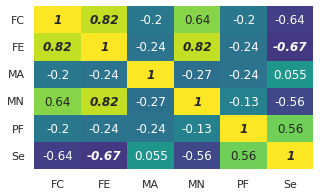

In [229]:
plot_same_baseline_diff_metrics_figure(scores_by_metric_with_baselines_dict, 'baseline_black')

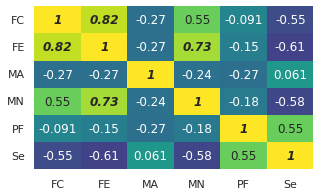

In [228]:
# ResNet-50 / ImageNet (with cameras)
short_labels = ['FC','FE', 'MA','MN','PF','Se']
tau_values, p_values = compute_corr_matrix_by_mean_score_aggreg(scores_by_metric_dict['resnet50']['imagenet'], metrics_with_different_baselines)
plot_corr_matrix(tau_values, p_values, short_labels, short_labels, fig_size=(5,3), rotate_x=False)

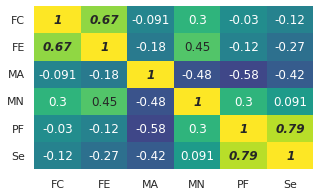

In [195]:
# ResNet-50 / CIFAR-10 (with cameras)
short_labels = ['FC','FE', 'MA','MN','PF','Se']
tau_values, p_values = compute_corr_matrix_by_mean_score_aggreg(scores_by_metric_dict['resnet50']['cifar10'], metrics_with_different_baselines)
plot_corr_matrix(tau_values, p_values, short_labels, short_labels, fig_size=(5,3), rotate_x=False)

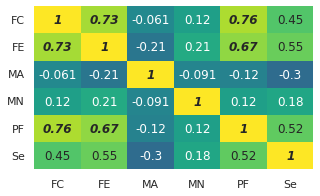

In [227]:
# ResNet-50 / ImageNet (with cameras)
short_labels = ['FC','FE', 'MA','MN','PF','Se']
tau_values, p_values = compute_corr_matrix_by_mean_score_aggreg(scores_by_metric_dict['vgg16']['imagenet'], metrics_with_different_baselines)
plot_corr_matrix(tau_values, p_values, short_labels, short_labels, fig_size=(5,3), rotate_x=False)

### Random

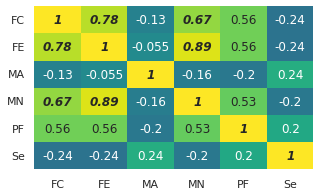

In [197]:
plot_same_baseline_diff_metrics_figure(scores_by_metric_with_baselines_dict, 'baseline_random')

### Uniform

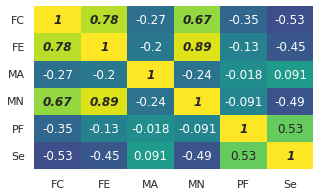

In [198]:
plot_same_baseline_diff_metrics_figure(scores_by_metric_with_baselines_dict, 'baseline_uniform')

### White

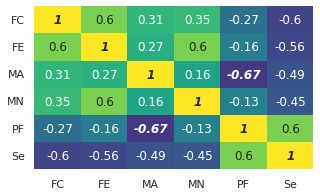

In [199]:
plot_same_baseline_diff_metrics_figure(scores_by_metric_with_baselines_dict, 'baseline_white')

## Faithfulness: same metric and different baselines

Only with ResNet-50 / ImageNet

In [200]:
def plot_same_metric_diff_baselines_figure(scores_dict, metric):
    selected_metrics = [f'{metric}_{baseline}' for baseline in baselines]
    short_labels = ['B','R', 'U','W']
    filename = f'pakdd2023_corr_matrix_{metric}'
    tau_values, p_values = compute_corr_matrix_by_mean_score_aggreg(scores_dict, selected_metrics)
    plot_corr_matrix(tau_values, p_values, short_labels, short_labels, filename=filename,
                     fig_size=(3,2), rotate_x=False)

### Faithfulness Correlation

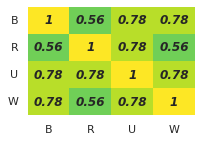

In [201]:
plot_same_metric_diff_baselines_figure(scores_by_metric_with_baselines_dict, 'Faithfulness Correlation')

### Faithfulness Estimate

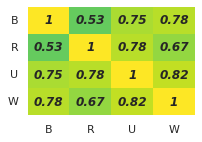

In [202]:
plot_same_metric_diff_baselines_figure(scores_by_metric_with_baselines_dict, 'Faithfulness Estimate')

### Monotonicity Arya

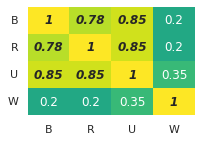

In [203]:
plot_same_metric_diff_baselines_figure(scores_by_metric_with_baselines_dict, 'Monotonicity Arya')

### Monotonicity Nguyen

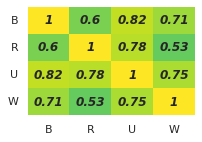

In [204]:
plot_same_metric_diff_baselines_figure(scores_by_metric_with_baselines_dict, 'Monotonicity Nguyen')

### Pixel-Flipping

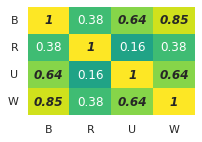

In [205]:
plot_same_metric_diff_baselines_figure(scores_by_metric_with_baselines_dict, 'Pixel-Flipping')

### Selectivity

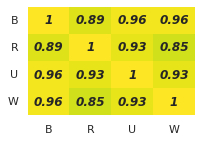

In [206]:
plot_same_metric_diff_baselines_figure(scores_by_metric_with_baselines_dict, 'Selectivity')

## Complexity

In [207]:
selected_metrics = ['Complexity','EffectiveComplexity','Sparseness']
labels = ['Complexity (C)', 'Effective Complexity (E)', 'Sparseness (S)']
short_labels = ['C','E', 'S']

### ResNet-50 / ImageNet

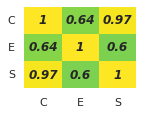

In [208]:
filename = 'pakdd2023_corr_matrix_complexity_resnet50_imagenet'
tau_values, p_values = compute_corr_matrix_by_mean_score_aggreg(scores_by_metric_dict['resnet50']['imagenet'], selected_metrics)
plot_corr_matrix(tau_values, p_values, short_labels, short_labels, filename=filename,
                 fig_size=(2,1.5), rotate_x=False)

### ResNet-50 / CIFAR-10

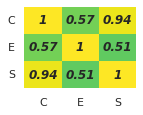

In [209]:
filename = 'pakdd2023_corr_matrix_complexity_resnet50_cifar10'
tau_values, p_values = compute_corr_matrix_by_mean_score_aggreg(scores_by_metric_dict['resnet50']['cifar10'], selected_metrics)
plot_corr_matrix(tau_values, p_values, short_labels, short_labels, filename=filename,
                 fig_size=(2,1.5), rotate_x=False)

### VGG-16 / ImageNet

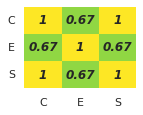

In [210]:
filename = 'pakdd2023_corr_matrix_complexity_vgg16_imagenet'
tau_values, p_values = compute_corr_matrix_by_mean_score_aggreg(scores_by_metric_dict['vgg16']['imagenet'], selected_metrics)
plot_corr_matrix(tau_values, p_values, short_labels, short_labels, filename=filename,
                 fig_size=(2,1.5), rotate_x=False)

## Randomization

In [211]:
selected_metrics = ['Model Parameter Randomisation', 'Random Logit']
labels = ['Model Parameter Randomisation (M)', 'Random Logit (R)']
short_labels = ['M','R']

### ResNet-50 / ImageNet

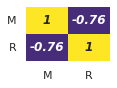

In [212]:
filename = 'pakdd2023_corr_matrix_randomization_resnet50_imagenet'
tau_values, p_values = compute_corr_matrix_by_mean_score_aggreg(scores_by_metric_dict['resnet50']['imagenet'], selected_metrics)
plot_corr_matrix(tau_values, p_values, short_labels, short_labels, filename=filename,
                 fig_size=(1.5,1), rotate_x=False)

### ResNet-50 / CIFAR-10

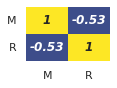

In [213]:
filename = 'pakdd2023_corr_matrix_randomization_resnet50_cifar10'
tau_values, p_values = compute_corr_matrix_by_mean_score_aggreg(scores_by_metric_dict['resnet50']['cifar10'], selected_metrics)
plot_corr_matrix(tau_values, p_values, short_labels, short_labels, filename=filename,
                 fig_size=(1.5,1), rotate_x=False)

### VGG-16 / ImageNet

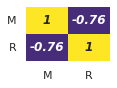

In [214]:
filename = 'pakdd2023_corr_matrix_randomization_vgg16_imagenet'
tau_values, p_values = compute_corr_matrix_by_mean_score_aggreg(scores_by_metric_dict['vgg16']['imagenet'], selected_metrics)
plot_corr_matrix(tau_values, p_values, short_labels, short_labels, filename=filename,
                 fig_size=(1.5,1), rotate_x=False)

## Robustness

In [215]:
selected_metrics = ['Avg-Sensitivity','Local Lipschitz Estimate', 'Max-Sensitivity']
labels = ['Avg-Sensitivity (A)', 'Local Lipschitz Estimate (L)', 'Max-Sensitivity (M)']
short_labels = ['A','L', 'M']

### ResNet-50 / ImageNet

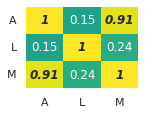

In [216]:
filename = 'pakdd2023_corr_matrix_robustness_resnet50_imagenet'
tau_values, p_values = compute_corr_matrix_by_mean_score_aggreg(scores_by_metric_dict['resnet50']['imagenet'], selected_metrics)
plot_corr_matrix(tau_values, p_values, short_labels, short_labels, filename=filename,
                 fig_size=(2,1.5), rotate_x=False)

### ResNet-50 / CIFAR-10

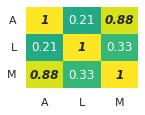

In [217]:
filename = 'pakdd2023_corr_matrix_robustness_resnet50_cifar10'
tau_values, p_values = compute_corr_matrix_by_mean_score_aggreg(scores_by_metric_dict['resnet50']['cifar10'], selected_metrics)
plot_corr_matrix(tau_values, p_values, short_labels, short_labels, filename=filename,
                 fig_size=(2,1.5), rotate_x=False)

### VGG-16 / ImageNet

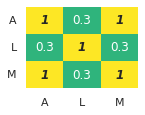

In [218]:
filename = 'pakdd2023_corr_matrix_robustness_vgg16_imagenet'
tau_values, p_values = compute_corr_matrix_by_mean_score_aggreg(scores_by_metric_dict['vgg16']['imagenet'], selected_metrics)
plot_corr_matrix(tau_values, p_values, short_labels, short_labels, filename=filename,
                 fig_size=(2,1.5), rotate_x=False)

## All metrics with default baselines (i.e. black)

### ResNet-50 / ImageNet

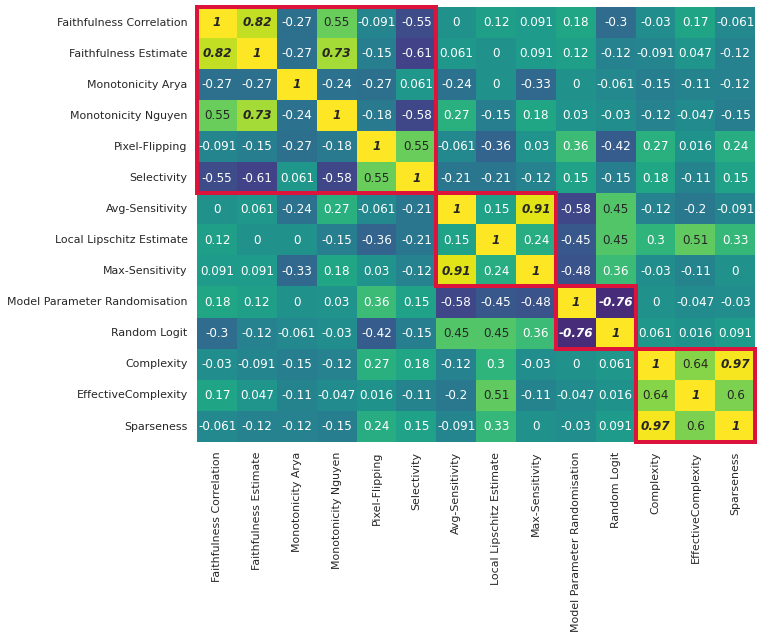

In [219]:
filename = 'pakdd2023_corr_matrix_all_metrics_resnet50_imagenet'
tau_values, p_values = compute_corr_matrix_by_mean_score_aggreg(scores_by_metric_dict['resnet50']['imagenet'], metrics)
plot_corr_matrix(tau_values, p_values, metrics, metrics, filename=filename,
                 fig_size=(10,8), subgroups=(6,3,2,3), rotate_x=False)

### ResNet-50 / CIFAR-10

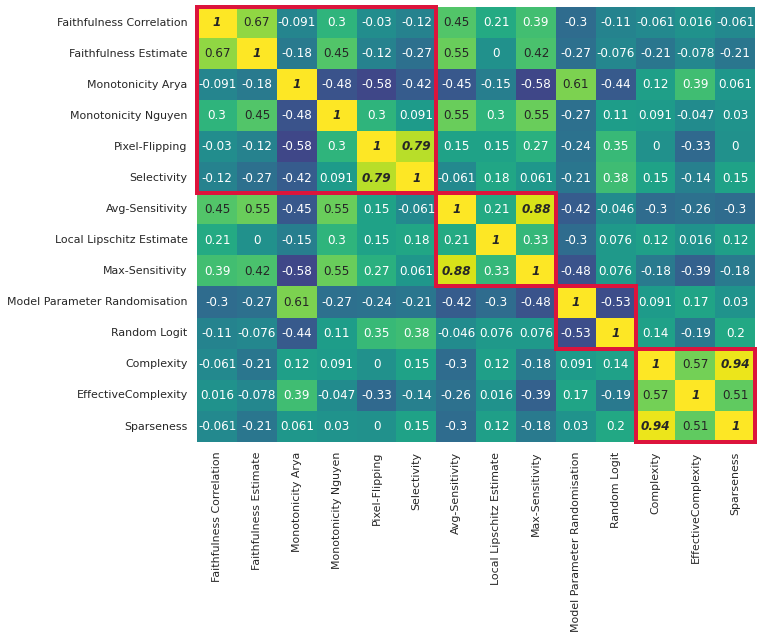

In [220]:
filename = 'pakdd2023_corr_matrix_all_metrics_resnet50_cifar10'
tau_values, p_values = compute_corr_matrix_by_mean_score_aggreg(scores_by_metric_dict['resnet50']['cifar10'], metrics)
plot_corr_matrix(tau_values, p_values, metrics, metrics, filename=filename,
                 fig_size=(10,8), subgroups=(6,3,2,3), rotate_x=False)

### VGG-16 / ImageNet

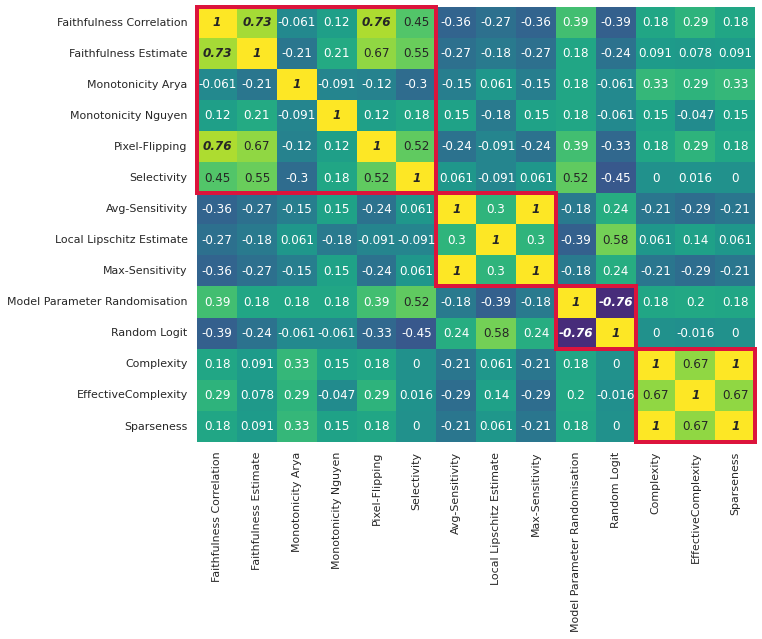

In [221]:
filename = 'pakdd2023_corr_matrix_all_metrics_vgg16_imagenet'
tau_values, p_values = compute_corr_matrix_by_mean_score_aggreg(scores_by_metric_dict['vgg16']['imagenet'], metrics)
plot_corr_matrix(tau_values, p_values, metrics, metrics, filename=filename,
                 fig_size=(10,8), subgroups=(6,3,2,3), rotate_x=False)

## Bump plots

In [222]:
def plot_bump_plot(scores_dict, metrics, model_name, dataset_name, filename=None):
    ranks_dict = {}

    for metric in metrics:
        ranks = np.array(list(map(rankdata, scores_dict[metric])))
        average_ranks = np.mean(ranks, axis=0)
        ranks_dict[metric] = average_ranks
        
    dummy_methods = ['random', 'sobel', 'gaussian']

    true_methods = ['integratedgrad','smoothgrad','guidedbackprop','rise','gradcam',
                    'scorecam','layercam','polycam', 'cameras']

    df_ranks = pd.DataFrame(ranks_dict, index=methods)

    df_ranks_sorted = df_ranks[metrics]

    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(ylim=(0.5, len(methods) + 0.51)))

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))

    yax2 = ax.secondary_yaxis("right")
    yax2.yaxis.set_major_locator(FixedLocator(df_ranks_sorted[df_ranks_sorted.columns[-1]].to_list()))
    yax2.yaxis.set_major_formatter(FixedFormatter(df_ranks_sorted.index))

    plt.rcParams.update({'font.size': 18})

    transposed = df_ranks_sorted.transpose()

    ax.plot(transposed[dummy_methods] ,"o-",mfc="w", linewidth = 3)
    ax.plot(transposed[true_methods] ,"o-",mfc="w", linewidth = 1)

    plt.xticks(rotation=-15, ha='left')
    ax.set(xlabel="Metric", ylabel="Rank",
           title=f"Method rank by metric ({model_name} / {dataset_name})")
    ax.grid(axis="x")

    plt.tight_layout()

    if filename:
        plt.savefig(f'./results/{filename}.eps', format='eps')

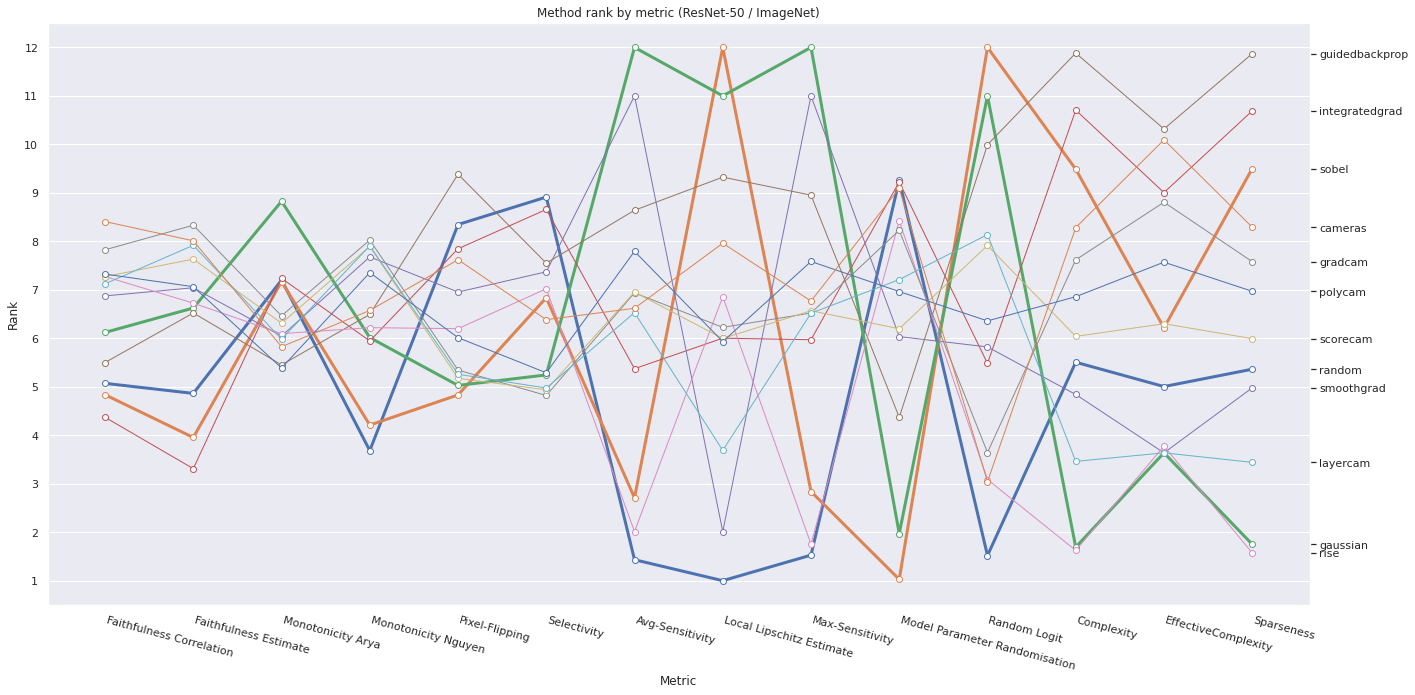

In [223]:
filename = 'pakdd2023_bump_plot_resnet50_imagenet'
plot_bump_plot(scores_by_metric_dict['resnet50']['imagenet'], metrics,
               'ResNet-50', 'ImageNet', filename=filename)

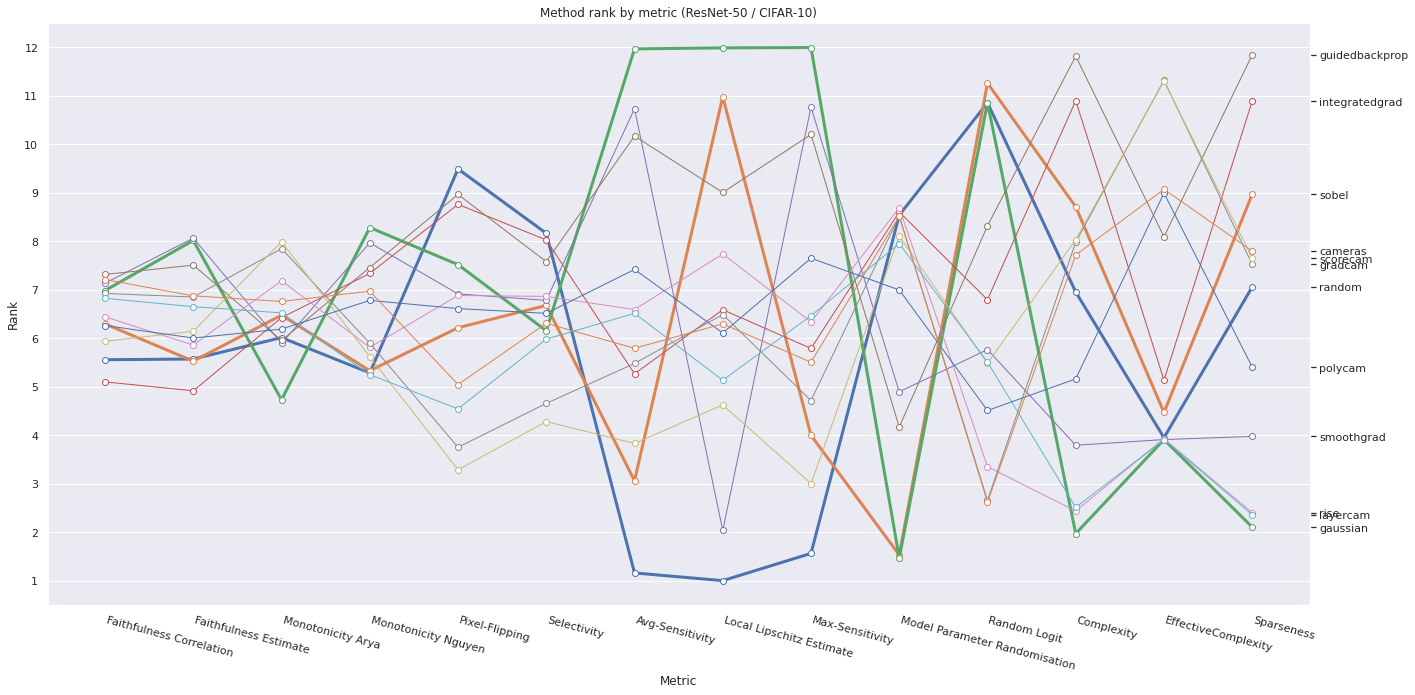

In [224]:
filename = 'pakdd2023_bump_plot_resnet50_cifar10'
plot_bump_plot(scores_by_metric_dict['resnet50']['cifar10'], metrics,
               'ResNet-50', 'CIFAR-10', filename=filename)

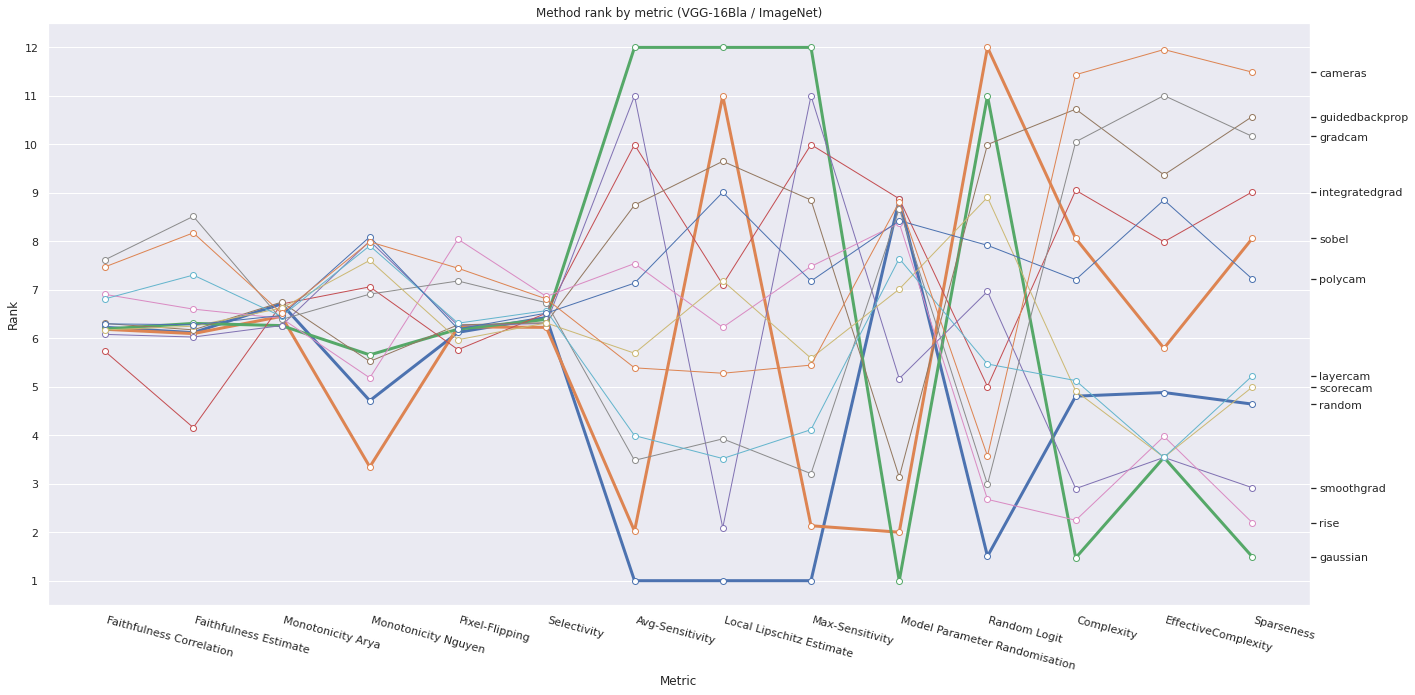

In [225]:
filename = 'pakdd2023_bump_plot_vgg16_imagenet'
plot_bump_plot(scores_by_metric_dict['vgg16']['imagenet'], metrics,
               'VGG-16Bla', 'ImageNet', filename=filename)